<div class="frontmatter text-center">
<h1>Geospatial Data Science</h1>
<h2>Lecture 8: OpenStreetMap and OSMnx</h2>
<h3>IT University of Copenhagen, Spring 2022</h3>
<h3>Instructor: Michael Szell</h3>
</div>

# Source
This notebook was adapted from:
* OSMnx examples: https://github.com/gboeing/osmnx-examples
* pyrosm examples: https://pyrosm.readthedocs.io/en/latest/basics.html#read-street-networks

# OSMnx overview: querying, simplifying, visualizing, saving

In [1]:
import geopandas as gpd
import osmnx as ox
import numpy as np
import networkx as nx
import pandas as pd

%matplotlib inline
ox.__version__

'1.2.2'

您可以使用 `ox.config()` 来配置 OSMnx。 请参阅 [文档](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.utils.config) 了解您可以配置的设置。 例如，默认情况下 OSMnx 缓存所有服务器响应，以防止每次运行时重复访问服务器以获取相同的查询。 这既使我们的代码在后续运行中更快，又帮助我们成为服务器的“好邻居”。 但是您可以使用 `use_cache` 参数关闭（或重新打开）缓存。 任何未传递给配置函数的参数都会在您调用它时（重新）设置为其原始默认值。

In [2]:
# turn response caching off
# ox.config(use_cache=False)

# turn it back on and turn on/off logging to your console
ox.config(use_cache=True, log_console=False)

d:\work\miniconda3\envs\OSMNX\lib\site-packages\osmnx\utils.py:192: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  warnings.warn(


## 第 1 部分：从 OpenStreetMap 获取地点边界

OSMnx 允许您从 OpenStreetMap 下载地点边界几何图形，投影它们并绘制它们。 有关按地点查询的更深入演示，请参阅 [this notebook](03-graph-place-queries.ipynb)。

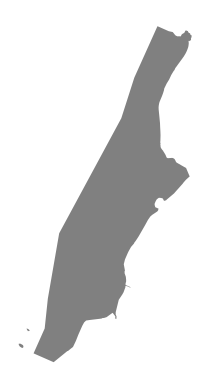

In [3]:
# get the boundary polygon for manhattan, project it, and plot it
city = ox.geocode_to_gdf("Manhattan")
city_proj = ox.project_gdf(city)
ax = city_proj.plot(fc="gray", ec="none")
ax.axis("off");

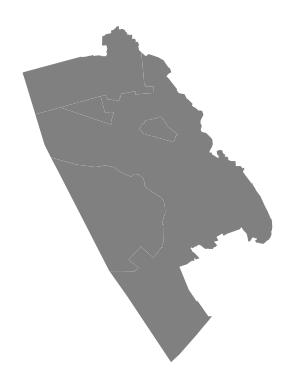

In [4]:
# get boundary polygons for several cities, save as GeoPackage, project to UTM, and plot
place_names = [
    "Berkeley, California, USA",
    "Oakland, California, USA",
    "Piedmont, California, USA",
    "Emeryville, California, USA",
    "Alameda, Alameda County, CA, USA",
]
east_bay = ox.geocode_to_gdf(place_names)
east_bay.to_file("files/east_bay.gpkg", driver="GPKG")
east_bay = ox.project_gdf(east_bay)
ax = east_bay.plot(fc="gray", ec="none")
_ = ax.axis("off")

In [5]:
# if you know the OSM ID of the place(s) you want, you can query it directly
ox.geocode_to_gdf(["R2192363", "N240109189", "W427818536"], by_osmid=True)

geometry  bbox_north  bbox_south  \
0  MULTIPOLYGON (((12.45300 55.71222, 12.45309 55...   55.732703   55.612861   
1                          POINT (13.38886 52.51704)   52.677036   52.357036   
2  POLYGON ((-73.98141 40.76846, -73.98135 40.768...   40.800314   40.764745   

   bbox_east  bbox_west   place_id  osm_type     osm_id        lat        lon  \
0  12.734246  12.453000  346452677  relation    2192363  55.655547  12.601643   
1  13.548860  13.228860     547217      node  240109189  52.517037  13.388860   
2 -73.949606 -73.981408  202812447       way  427818536  40.782773 -73.965363   

                                        display_name     class  \
0  Copenhagen Municipality, Capital Region of Den...  boundary   
1                                    Berlin, Germany     place   
2  Central Park, New York County, New York, Unite...   leisure   

             type  importance  
0  administrative    0.495253  
1            city    0.375000  
2            park    0.565172

## 第 2 部分：下载和建模街道网络

OSMnx 允许您下载街道网络数据并构建经过拓扑校正的街道网络、投影和绘制网络，并将街道网络保存为 SVG、GraphML 文件、GeoPackage 或 shapefile 以供以后使用。 街道网络是有向的并保持单向方向性。 有关创建街道网络的更深入演示，请参阅 [this notebook](03-graph-place-queries.ipynb)。

您可以通过提供 OSMnx 以下任何一项来下载街道网络（在下面的示例中演示）：
   - 边界框
   - 经纬度点加距离
   - 地址加距离
   - 地名或地名列表（自动地理编码并获取边界）
   - 所需街道网络边界的多边形
   - .osm 格式的 xml 文件

您还可以指定几种不同的网络类型：
   - 'drive' - 获得可驾驶的公共街道（但不是服务道路）
   - 'drive_service' - 获取可行驶的街道，包括辅助道路
   - 'walk' - 获取行人可以使用的所有街道和路径（此网络类型忽略单向方向性）
   - 'bike' - 获取骑车人可以使用的所有街道和路径
   - 'all' - 下载所有非私有 OSM 街道和路径（这是默认网络类型，除非您指定不同的网络类型）
   - 'all_private' - 下载所有 OSM 街道和路径，包括私人访问的

 #### 方法#1，传递一个边界框 ####
  这从边界框内的所有 OSM 节点和路径构建了网络。

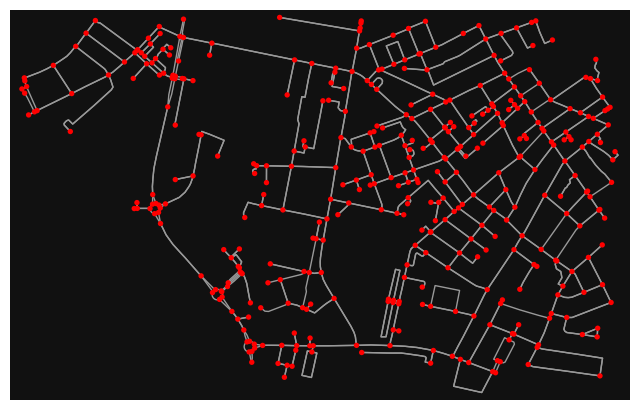

In [6]:
# define a bounding box in San Francisco
north, south, east, west = 37.79, 37.78, -122.41, -122.43
# define a bounding box around ITU
north, south, east, west = 55.6646, 55.6540, 12.5767, 12.6077

# create network from that bounding box
G = ox.graph_from_bbox(north, south, east, west, network_type="drive_service")
ox.plot_graph(G, node_color="r");

#### 方法 #2，以米为单位传递经纬度点和边界框距离
这会在该点的北、南、东和西创建一个 *n* 米的边界框，然后从边界框内的所有 OSM 节点和路径构建网络。

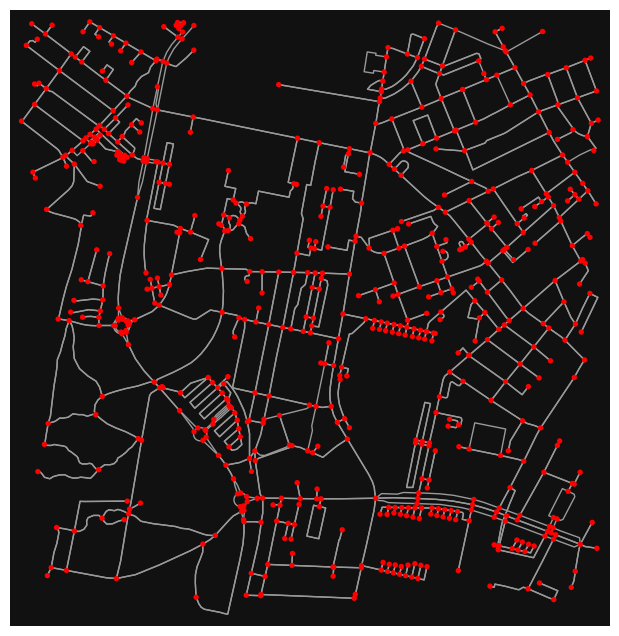

In [7]:
# define a point at the corner of California St and Mason St in SF
location_point = (37.791427, -122.410018)
# define a point at ITU
location_point = (55.659323, 12.591472)

# create bikeable network from point, inside bounding box of N, S, E, W each 750m from point
G = ox.graph_from_point(location_point, dist=750, dist_type="bbox", network_type="bike")
ox.plot_graph(G, node_color="r");

#### 方法 #3，以米为单位传递经纬度点和 *network* 距离 ####

这会在该点的北、南、东和西创建一个 *n* 米的边界框，然后从边界框内的所有 OSM 节点和路径构建网络。 然后它通过删除距离网络上的点超过 *n* 米的所有节点来截断网络。

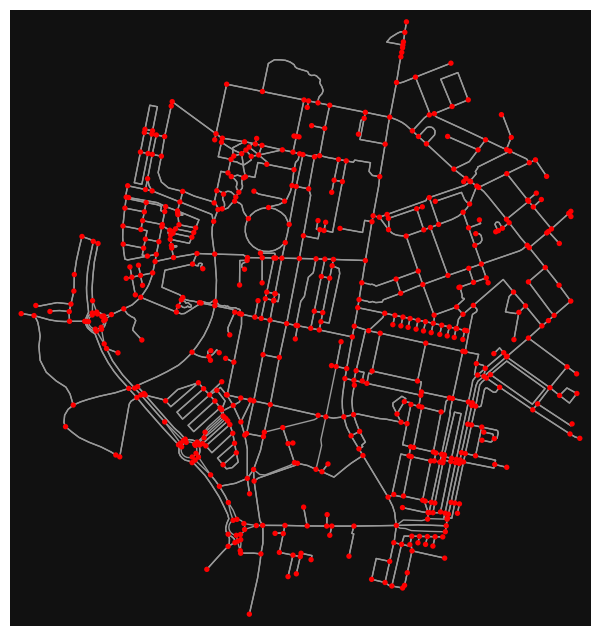

In [8]:
# same point again, but create network only of nodes within 750m along the network from point
G1 = ox.graph_from_point(location_point, dist=750, dist_type="network")
ox.plot_graph(G1, node_color="r");

*注意* 上图显示了距 `location_point` 500 米（沿网络行驶的距离）范围内的网络。 默认情况下，`network_type` 参数值为 'all'，这意味着我们不会过滤掉限制某些类型流量的路径。 这也意味着单向街道被认为是单向的，您不能沿着错误的方向行驶。 因此，500m 仅考虑您仅在允许的街道方向行驶时可以在 500m 内到达的那些节点。 相反（如下），我们可以指定 `network_type='walk'` 来构建仅允许步行路径的街道网络。 这也使得有向网络中的每条路径都是双向的，因为您可以在单行道的人行道上沿任一方向行走。 因此，500m 现在考虑了您在任一方向（即使是单行道）行驶时可以在 500m 范围内到达的那些节点。

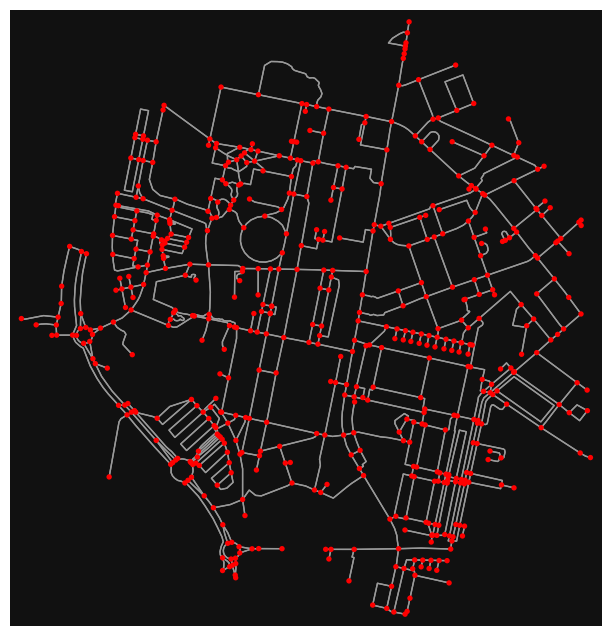

In [9]:
# create network only of nodes within 750m walking along the network from point
G2 = ox.graph_from_point(location_point, dist=750, dist_type="network", network_type="walk")
ox.plot_graph(G2, node_color="r");

#### 方法#4，以米为单位传递地址和距离（*边界框*或*网络*）
这会对地址进行地理编码，创建边界框，下载网络，然后按网络距离截断它（如果 distance_type='network'）。

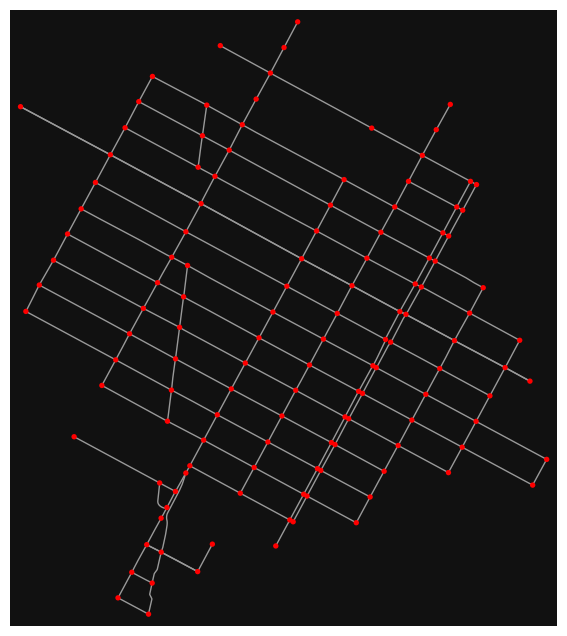

In [10]:
# network from address, including only nodes within 1km along the network from the address
G = ox.graph_from_address(
    address="350 5th Ave, New York, NY",
    dist=1000,
    dist_type="network",
    network_type="drive",
)

# you can project the network to UTM (zone calculated automatically)
G_projected = ox.project_graph(G)
ox.plot_graph(G_projected, node_color="r");

#### 方法#5，传递地名

这会对地点名称进行地理编码，获取地点的边界形状多边形和边界框，下载边界框内的网络，然后将其截断为地点的边界多边形。

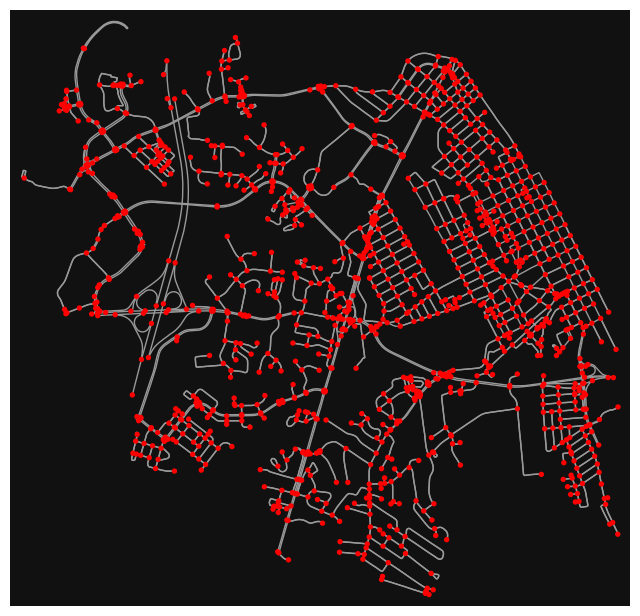

In [11]:
G = ox.graph_from_place("Frederiksberg", network_type="drive")
ox.plot_graph(G, node_color="r");

这不是我们要找的 Frederiksberg！ 它是弗吉尼亚州的弗雷德里克斯堡。 发生了什么？ 名称通过 nominatim 解析，它返回第一个结果是多边形或多边形。 所有结果都列在这里：https://nominatim.openstreetmap.org/ui/search.html?q=Frederiksberg

要获取不同的结果，请使用参数`which_result`：

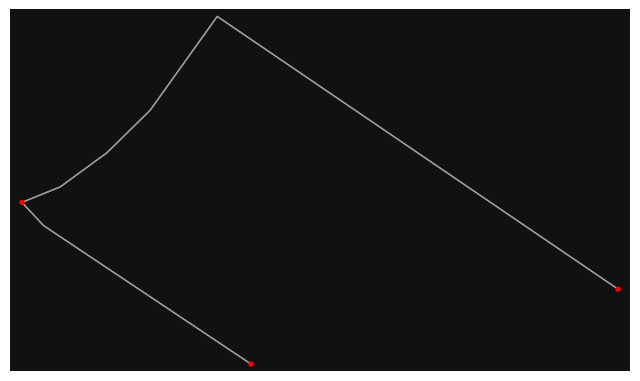

In [12]:
# Frederiksberg, Sorø Municipality, Denmark
G = ox.graph_from_place("Frederiksberg", network_type="drive", which_result=6)
ox.plot_graph(G, node_color="r");

但是我们要找的 Frederiksberg 在哪里？

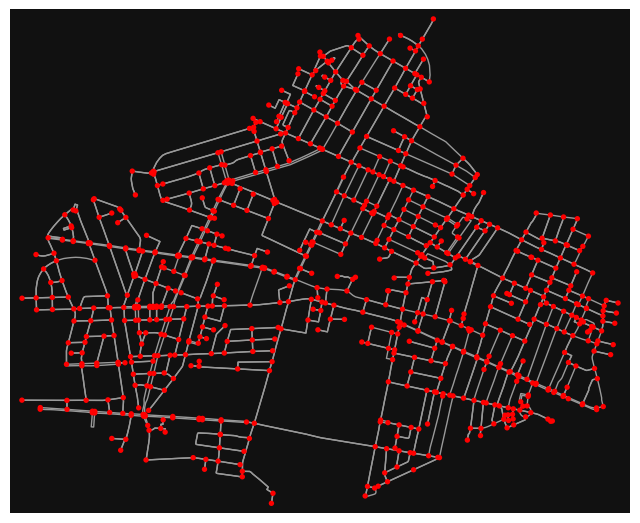

In [13]:
# Frederiksberg Municipality, Denmark
G_fred = ox.graph_from_place("Frederiksberg Municipality", network_type="drive")
G_fred = ox.project_graph(G_fred)
ox.plot_graph(G_fred, node_color="r");

In [14]:
G_fred

请注意，这是一个多重有向图，即有向多重图（可能存在平行边）。 因为一对节点之间可以有多个链接，每个链接用一个三元组标识：(node1id, node2id, counter)

In [15]:
list(G_fred.edges)[:10]

[(576734, 576735, 0),
 (576734, 281882807, 0),
 (576734, 282822735, 0),
 (576734, 929287662, 0),
 (576735, 576734, 0),
 (576735, 2955858500, 0),
 (576735, 282823010, 0),
 (281882807, 576734, 0),
 (281882807, 281882851, 0),
 (281882807, 792862, 0)]

当心奇怪或意想不到的行政区域，因此请务必仔细检查您的结果：

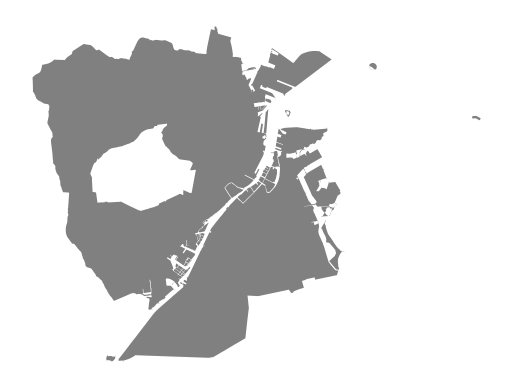

In [16]:
# get the boundary polygon for Copenhagen, project it, and plot it
city = ox.geocode_to_gdf("Copenhagen municipality")
city_proj = ox.project_gdf(city)
ax = city_proj.plot(fc="gray", ec="none")
ax.axis("off");

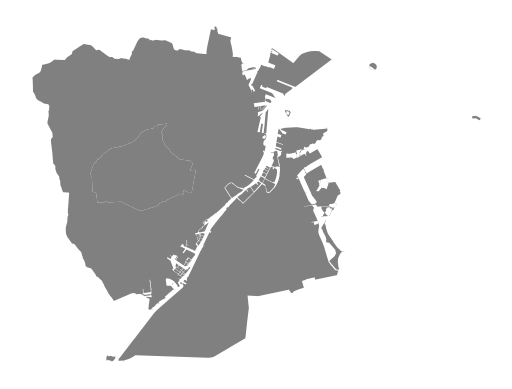

In [17]:
# get the boundary polygon for Copenhagen including Frederiksberg, project it, and plot it
city = ox.geocode_to_gdf(["Copenhagen municipality", "Frederiksberg municipality"])
city_proj = ox.project_gdf(city)
ax = city_proj.plot(fc="gray", ec="none")
ax.axis("off");

如果你仔细观察，你会发现腓特烈斯贝周围有一条细线。 因此，这只是绘制了两个区域，但如果您想进一步使用这些形状，例如作为选择更多对象的边界，您可以使用 shapely 溶解多边形：

In [18]:
city_proj

geometry  bbox_north  bbox_south  \
0  MULTIPOLYGON (((339990.055 6176990.248, 339995...   55.732703   55.612861   
1  POLYGON ((342263.138 6173216.083, 342337.861 6...   55.697681   55.666502   

   bbox_east  bbox_west   place_id  osm_type   osm_id        lat        lon  \
0  12.734246  12.453000  346452677  relation  2192363  55.655547  12.601643   
1  12.557342  12.491315  298394793  relation  2186660  55.681939  12.523431   

                                        display_name     class  \
0  Copenhagen Municipality, Capital Region of Den...  boundary   
1  Frederiksberg Municipality, Capital Region of ...  boundary   

             type  importance  
0  administrative    0.695253  
1  administrative    0.677530

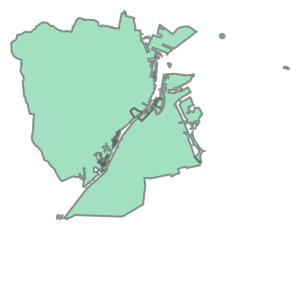

In [19]:
from shapely.ops import unary_union
unary_union([p for p in city_proj.geometry])

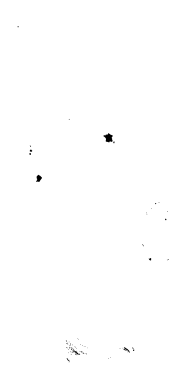

In [20]:
# get the boundary polygon for France, project it, and plot it
france = ox.geocode_to_gdf("France")
france = ox.project_gdf(france)
ax = france.plot(fc="k", ec="none")
ax.axis("off");

d:\work\miniconda3\envs\OSMNX\lib\site-packages\osmnx\graph.py:488: UserWarning: the graph-level street_count attribute will likely be inaccurate when you set clean_periphery=False
  warnings.warn(msg)


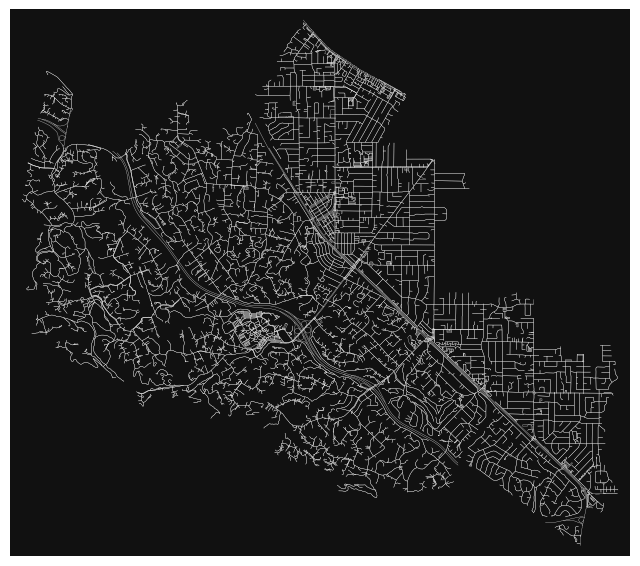

In [21]:
# you can also pass multiple places as a mixed list of strings and/or dicts
places = [
    "Los Altos, California, USA",
    {"city": "Los Altos Hills", "state": "California"},
    "Loyola, California",
]
G = ox.graph_from_place(places, clean_periphery=False)

# save to disk as GeoPackage file then plot
ox.save_graph_geopackage(G)
ox.plot_graph(G, node_size=0, edge_color="w", edge_linewidth=0.2);

#### 方法#6，传递一个多边形

此示例从 shapefile 加载 [Mission District](http://www.zillow.com/howto/api/neighborhood-boundaries.htm) 的多边形，然后在其边界框内下载网络，然后修剪所有节点 位于该地点的边界多边形之外。

In [22]:
calif = gpd.read_file("files/ZillowNeighborhoods-CA")
calif

STATE   COUNTY     CITY          NAME  REGIONID  \
0      CA  Alameda  Fremont      28 Palms  272706.0   
1      CA  Alameda  Fremont     Ardenwood  268001.0   
2      CA  Alameda  Fremont      Baylands  268017.0   
3      CA  Alameda  Fremont        Blacow  268026.0   
4      CA  Alameda  Fremont     Brookvale  268034.0   
..    ...      ...      ...           ...       ...   
943    CA     Yolo    Davis  Wildhorse Gc  268595.0   
944    CA     Yolo    Davis    Willowbank  268598.0   
945    CA     Yolo    Davis   Willowcreek  268599.0   
946    CA     Yolo    Davis    Woodbridge  276117.0   
947    CA     Yolo    Davis         Woods  268609.0   

                                              geometry  
0    POLYGON ((-121.98757 37.52286, -121.98773 37.5...  
1    POLYGON ((-122.04133 37.56604, -122.04069 37.5...  
2    POLYGON ((-121.94596 37.49091, -121.93807 37.4...  
3    POLYGON ((-121.97197 37.52264, -121.97077 37.5...  
4    MULTIPOLYGON (((-122.00390 37.58150, -121.9969...  
..                                                 ...  
943  POLYGON ((-121.71346 38.56853, -121.71343 38.5...  
944  POLYGON ((-121.69846 38.54302, -121.69627 38.5...  
945  POLYGON ((-121.70240 38.54599, -121.70245 38.5...  
946  POLYGON ((-121.70240 38.54599, -121.69837 38.5...  
947  POLYGON ((-121.78647 38.55818, -121.78660 38.5...  

[948 rows x 6 columns]

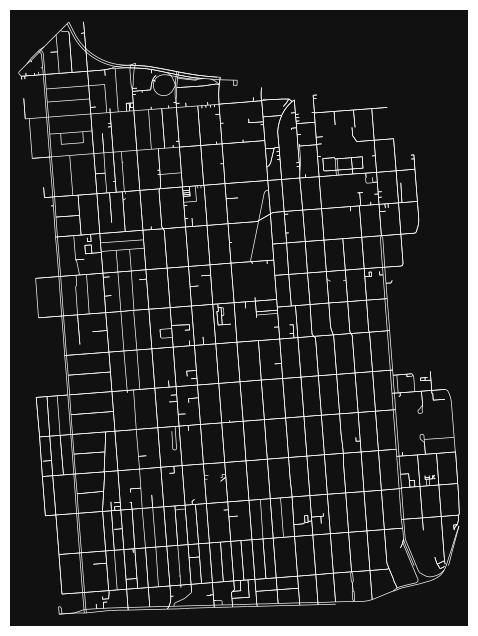

In [23]:
mission_district = calif[(calif["CITY"] == "San Francisco") & (calif["NAME"] == "Mission")]
polygon = mission_district["geometry"].iloc[0]

G2 = ox.graph_from_polygon(polygon, network_type="drive_service")
ox.plot_graph(G2, node_size=0, edge_color="w", edge_linewidth=0.5);

#### 方法 #7，加载一个 .osm xml 文件

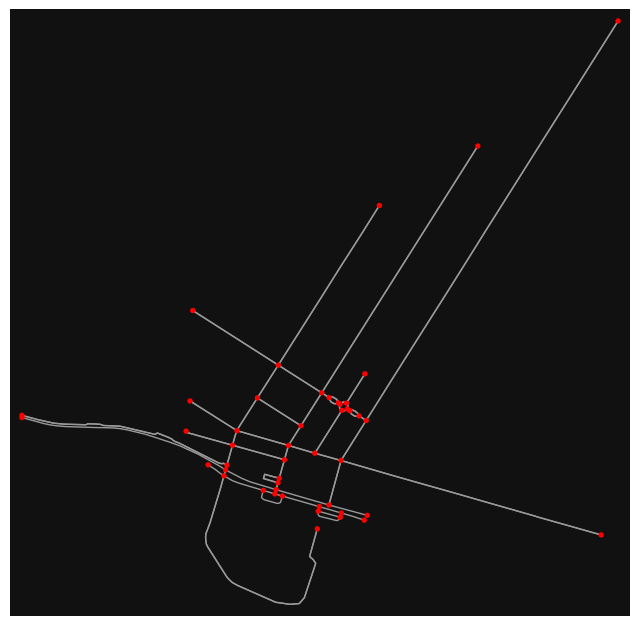

In [24]:
# create graph from .osm extract file
G = ox.graph_from_xml("files/West-Oakland.osm.bz2")
ox.plot_graph(G, node_color="r");

## 第 3 部分：简化街道网络拓扑

简化通常由 OSMnx 在后台自动完成，但我们可以分解它看看它是如何工作的。 OpenStreetMap 节点很奇怪。 它们包括交叉路口，但它们还包括沿街道弯曲的单个街区的所有点。 后者不是图论意义上的节点，因此我们通过算法将它们移除，并将“真实”网络节点之间的边集合并为一条边。 有两种简化模式，严格和非严格。 主要区别在于，与严格模式不同，非严格模式允许简化为“扩展图”（即，如果图是无向的，只要入射边具有不同的 OSM ID，节点的度数为 2）。

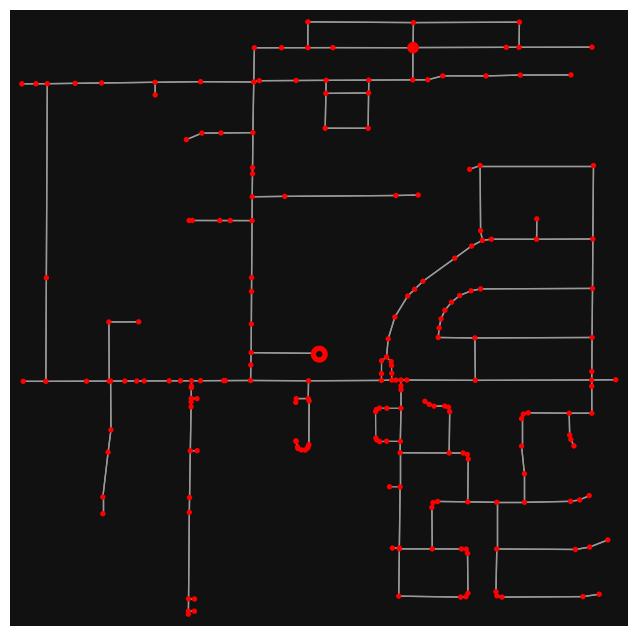

In [25]:
# create a network around some (lat, lng) point but do not simplify it yet
location_point = (33.299896, -111.831638)
G = ox.graph_from_point(location_point, network_type="drive_service", dist=500, simplify=False)
ox.plot_graph(G, node_color="r");

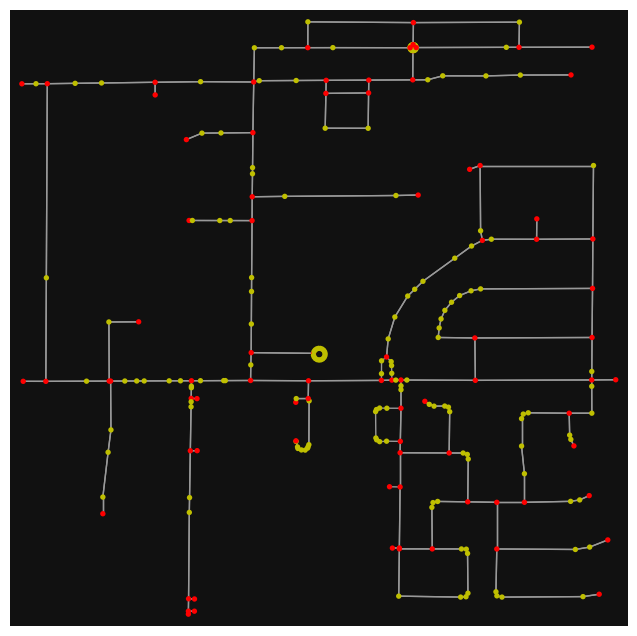

In [26]:
# turn off strict mode and see what nodes we'd remove, in yellow
nc = ["r" if ox.simplification._is_endpoint(G, node) else "y" for node in G.nodes()]
fig, ax = ox.plot_graph(G, node_color=nc);

上面的点是 OSM 节点。 我们将删除黄色节点，因为它们不是真正的网络节点（交叉路口/死胡同）。

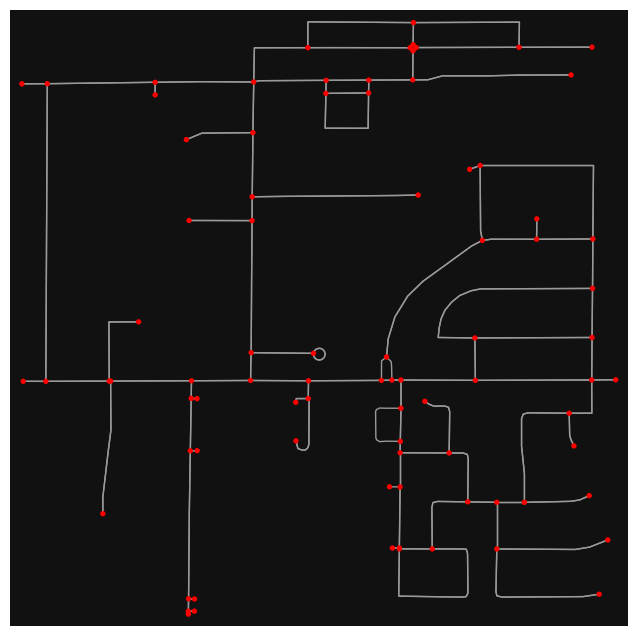

In [27]:
# simplify the network
G = ox.simplify_graph(G)
ox.plot_graph(G, node_color="r");

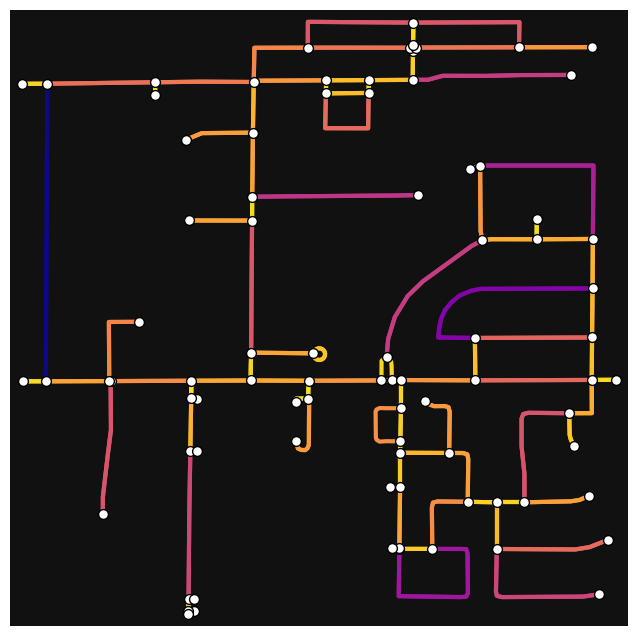

In [28]:
# show the simplified network with edges colored by length
ec = ox.plot.get_edge_colors_by_attr(G, attr="length", cmap="plasma_r")
fig, ax = ox.plot_graph(
    G, node_color="w", node_edgecolor="k", node_size=50, edge_color=ec, edge_linewidth=3
)

In [29]:
ec

41542771     41542772     0     (0.990439, 0.796859, 0.14787, 1.0)
                          1     (0.615812, 0.094564, 0.61714, 1.0)
             7655352447   0    (0.940015, 0.975158, 0.131326, 1.0)
41542772     41542771     0     (0.990439, 0.796859, 0.14787, 1.0)
                          1     (0.615812, 0.094564, 0.61714, 1.0)
                                              ...                 
10263950600  3851123455   0    (0.979644, 0.854866, 0.142453, 1.0)
             10263950598  0     (0.946602, 0.95519, 0.150328, 1.0)
10288549305  3545571404   0      (0.964021, 0.90795, 0.14937, 1.0)
             42397551     0     (0.910098, 0.439268, 0.34961, 1.0)
             41544344     0    (0.930798, 0.477867, 0.322697, 1.0)
Length: 192, dtype: object

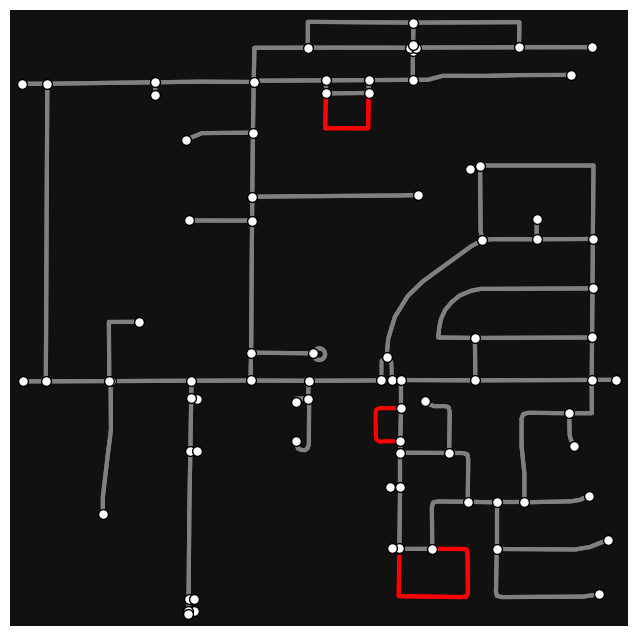

In [30]:
# highlight all parallel (multiple) edges
ec = ["gray" if k == 0 or u == v else "r" for u, v, k in G.edges(keys=True)]
fig, ax = ox.plot_graph(
    G, node_color="w", node_edgecolor="k", node_size=50, edge_color=ec, edge_linewidth=3
)

我们可以看到数据中的平行边：

In [31]:
list(G.edges)[:10]

[(41542771, 41542772, 0),
 (41542771, 41542772, 1),
 (41542771, 7655352447, 0),
 (41542772, 41542771, 0),
 (41542772, 41542771, 1),
 (41542772, 42238826, 0),
 (41542778, 41612013, 0),
 (41542778, 371845086, 0),
 (41542778, 42449935, 0),
 (41544344, 41756544, 0)]

### 突出显示腓特烈斯贝的地图属性

In [32]:
G_fred.edges[576734, 576735, 0]

{'osmid': [113540480, 1700501],
 'lanes': '2',
 'name': 'Nordre Fasanvej',
 'highway': 'tertiary',
 'maxspeed': '50',
 'oneway': False,
 'reversed': False,
 'length': 154.328,
 'geometry': <shapely.geometry.linestring.LineString at 0x1b496e03250>}

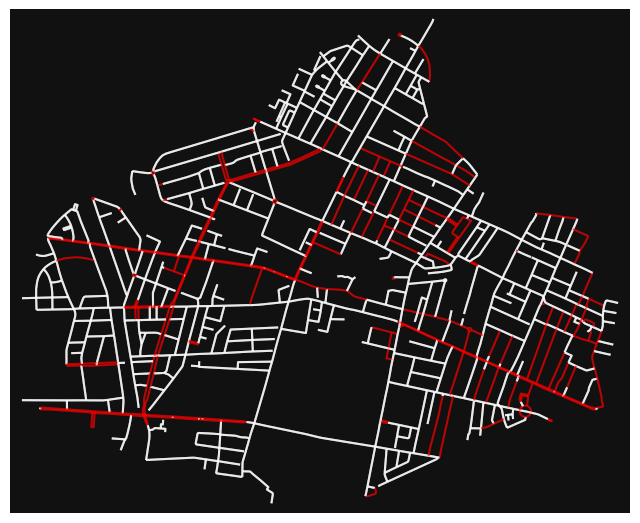

In [33]:
# highlight all one-way edges in the Frederiksberg network from earlier
ec = ["r" if data["oneway"] else "w" for u, v, key, data in G_fred.edges(keys=True, data=True)]
fig, ax = ox.plot_graph(G_fred, node_size=0, edge_color=ec, edge_linewidth=1.5, edge_alpha=0.7)

请注意，由两条（最小间隔）车道组成的街道可能会将其车道标记为“单向”，但实际上街道是双向的！ 例如，地图左下方的 Roskildevej：

<img src="files/roskildevej.jpg">

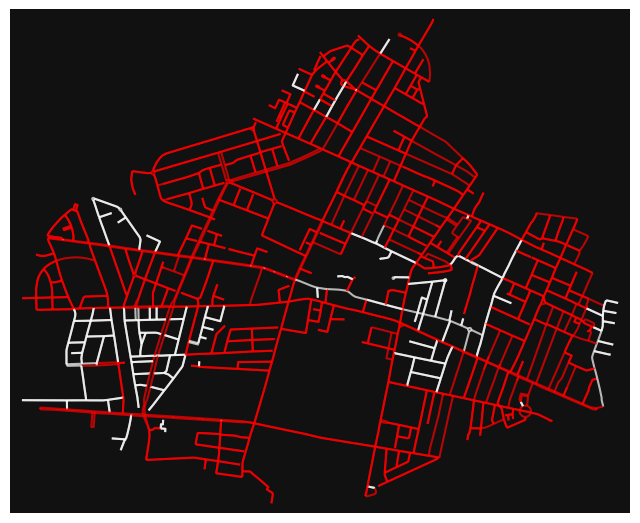

In [34]:
# highlight all speed limit 50 edges in the Frederiksberg network from earlier
ec = ["r" if "maxspeed" in data and data["maxspeed"] == "50" else "w" for u, v, key, data in G_fred.edges(keys=True, data=True)]
fig, ax = ox.plot_graph(G_fred, node_size=0, edge_color=ec, edge_linewidth=1.5, edge_alpha=0.7)

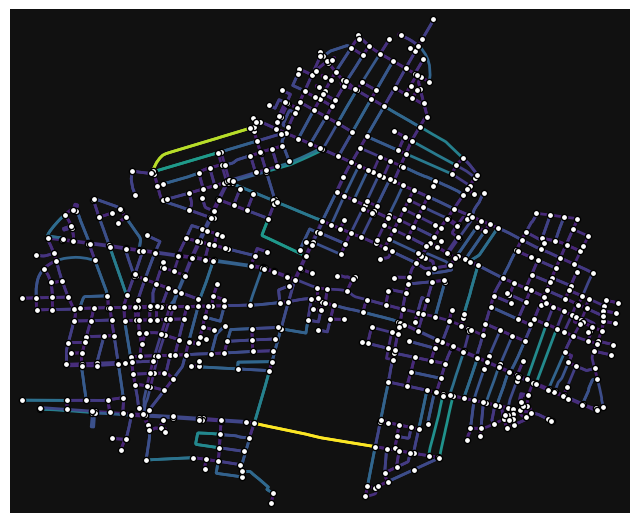

In [35]:
# Show edges colored by length
ec = ox.plot.get_edge_colors_by_attr(G_fred, attr="length", cmap="viridis")
fig, ax = ox.plot_graph(
    G_fred, node_color="w", node_edgecolor="k", node_size=20, edge_color=ec, edge_linewidth=2
)

## 第 4 部分：将网络保存到磁盘

有关将网络保存到磁盘或从磁盘加载网络的更多示例，请参阅 [this notebook](05-save-load-networks.ipynb)。

In [36]:
# save street network as GeoPackage to work with in GIS
ox.save_graph_geopackage(G_fred, filepath="network.gpkg")

In [37]:
# save street network as GraphML file to work with later in OSMnx or networkx or gephi
ox.save_graphml(G_fred, filepath="network.graphml")

# 路线、速度估算和旅行时间

包括通过 OSMnx 中的内置多处理进行并行化最短路径求解。

## 1. 使用 OSMnx 进行快速最近节点/边缘搜索

nearest_nodes 和 nearest_edges 函数采用 x 和 y（或 lng/lat）坐标数组，并向每个坐标返回最近的节点/边。

In [38]:
# randomly sample n points spatially-constrained to the network's geometry
points = ox.utils_geo.sample_points(ox.get_undirected(G_fred), n=30)
X = points.x.values
Y = points.y.values
X0 = X.mean()
Y0 = Y.mean()

(points, X, Y, X0, Y0)

(u           v           key
 18165937    1787984577  0      POINT (343611.058 6172386.975)
 20942944    20942945    0      POINT (342903.552 6173054.152)
 20908194    20908221    0      POINT (343256.010 6172603.680)
 20942950    20942951    0      POINT (342928.161 6172948.976)
 286651240   8447078630  0      POINT (344136.662 6174086.246)
 8078412     8078411     0      POINT (344309.820 6174251.168)
 8200942     8201657     0      POINT (345279.364 6174096.595)
 26630861    26630857    0      POINT (345112.754 6172803.886)
 8088738     279897584   0      POINT (343549.742 6173171.078)
 20942972    20974554    0      POINT (343046.033 6172433.802)
 20974564    1648230952  0      POINT (343609.024 6172396.561)
 781542      8200941     0      POINT (345397.181 6174000.931)
 814211      814227      0      POINT (346202.736 6173003.378)
 7786966     706771322   0      POINT (345254.154 6173632.391)
 26630855    26630857    0      POINT (345179.104 6172769.457)
 1621332206  1065826623  0

In [39]:
# find each nearest node to several points, and optionally return distance
nodes, dists = ox.nearest_nodes(G_fred, X, Y, return_dist=True)
(nodes[:4],dists[:4])

([1787984577, 20942944, 20908221, 20942951],
 [33.29128102788842, 67.0233405407097, 25.798836998476823, 7.942714683747299])

In [40]:
# or, find the nearest node to a single point
node = ox.nearest_nodes(G_fred, X0, Y0)
node

278648601

In [41]:
# find each nearest edge to several points, and optionally return distance
edges, dists = ox.nearest_edges(G_fred, X, Y, return_dist=True)
(edges[:4],dists[:4])

([(1787984577, 18165937, 0),
  (20942945, 20942944, 0),
  (20908194, 20908221, 0),
  (20942951, 20942950, 0)],
 [1.4347791779748784e-11,
  5.5422002349670835e-11,
  3.0266269282918657e-10,
  3.7440981217102013e-10])

In [42]:
# find the nearest edge to a single point
edge = ox.nearest_edges(G_fred, X0, Y0)
edge

(278648601, 282822564, 0)

## 2. 按距离的基本路由

选择两个节点。 然后找到起点和终点之间的最短路径，使用 weight='length' 通过最小化行进距离找到最短路径（否则它将每条边视为 weight=1）。

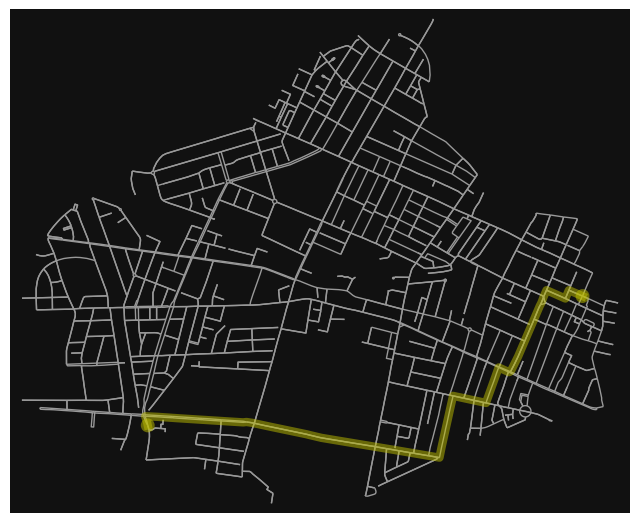

In [43]:
# find the shortest path (by distance) between these nodes then plot it
orig = list(G_fred)[41]
dest = list(G_fred)[220]
route = ox.shortest_path(G_fred, orig, dest, weight="length")
fig, ax = ox.plot_graph_route(G_fred, route, route_color="y", route_linewidth=6, node_size=0)

或者获取 *k* 最短路径，由某些属性加权：

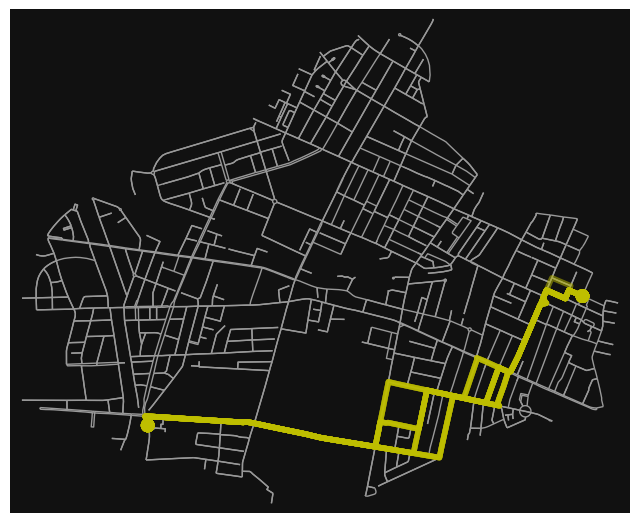

In [44]:
routes = ox.k_shortest_paths(G_fred, orig, dest, k=20, weight="length")
fig, ax = ox.plot_graph_routes(G_fred, list(routes), route_colors="y", route_linewidth=4, node_size=0)

## 3. 估算行驶速度和时间

`add_edge_speeds` 函数将边缘速度（每小时公里）添加到图形中作为新的 `speed_kph` 边缘属性。 根据每种高速公路类型的边的平均“最大速度”值估算所有边的自由流动行驶速度。 这种均值估算显然是不精确的，调用者可以通过传入与当地限速标准相对应的“hwy_speeds”和/或“fallback”参数来覆盖它。 有关详细信息，请参阅文档字符串。

In [45]:
# impute speed on all edges missing data
G = ox.add_edge_speeds(G_fred)

# calculate travel time (seconds) for all edges
G = ox.add_edge_travel_times(G)

In [46]:
# see mean speed/time values by road type
edges = ox.graph_to_gdfs(G, nodes=False)
edges["highway"] = edges["highway"].astype(str)
edges.groupby("highway")[["length", "speed_kph", "travel_time"]].mean().round(1)

length  speed_kph  travel_time
highway                                                         
['living_street', 'residential']    81.5       50.0          5.9
['residential', 'living_street']    81.5       50.0          5.9
['residential', 'unclassified']    246.5       40.0         22.2
living_street                      100.7       33.8         10.7
residential                        101.4       47.3          7.8
tertiary                            87.7       49.6          6.4
tertiary_link                        6.5       50.0          0.5
unclassified                        41.3       50.0          3.0

In [47]:
# same thing again, but this time pass in a few default speed values (km/hour)
# to fill in edges with missing `maxspeed` from OSM
hwy_speeds = {"residential": 30, "secondary": 50, "tertiary": 60}
G = ox.add_edge_speeds(G, hwy_speeds)
G = ox.add_edge_travel_times(G)

In [48]:
# calculate two routes by minimizing travel distance vs travel time
orig = list(G)[1]
dest = list(G)[120]
route1 = ox.shortest_path(G, orig, dest, weight="length")
route2 = ox.shortest_path(G, orig, dest, weight="travel_time")

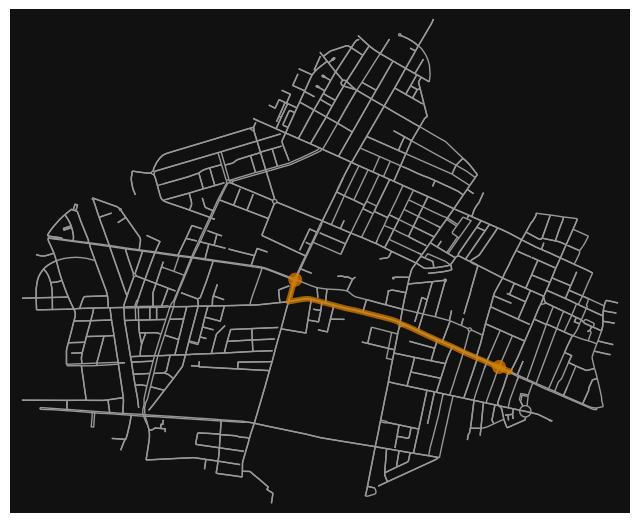

In [49]:
# plot the routes
fig, ax = ox.plot_graph_routes(
    G, routes=[route1, route2], route_colors=["r", "y"], route_linewidth=6, node_size=0
)

In [50]:
# compare the two routes
route1_length = int(sum(ox.utils_graph.get_route_edge_attributes(G, route1, "length")))
route2_length = int(sum(ox.utils_graph.get_route_edge_attributes(G, route2, "length")))
route1_time = int(sum(ox.utils_graph.get_route_edge_attributes(G, route1, "travel_time")))
route2_time = int(sum(ox.utils_graph.get_route_edge_attributes(G, route2, "travel_time")))
print("Route 1 is", route1_length, "meters and takes", route1_time, "seconds.")
print("Route 2 is", route2_length, "meters and takes", route2_time, "seconds.")

Route 1 is 1808 meters and takes 130 seconds.
Route 2 is 1808 meters and takes 130 seconds.


黄色路线最大限度地减少了旅行时间，因此比红色路线更长但更快。

有关旅行时间的更多示例，请参阅 [等时线示例](https://github.com/gboeing/osmnx-examples/blob/main/notebooks/13-isolines-isochrones.ipynb)。

有关路由的更多示例，包括使用高程作为阻抗，请参阅[elevations example](https://github.com/gboeing/osmnx-examples/blob/main/notebooks/12-node-elevations-edge-grades.ipynb).

## 4.多处理

计算很多最短路径可能会很慢，但 OSMnx 具有内置的最短路径求解器并行化和多处理，请参阅：https://github.com/gboeing/osmnx-examples/blob/main/notebooks/02-routing-speed- 时间.ipynb。

我建议使用 igraph 作为更快的替代方法：https://igraph.org/python/

# 简化网络拓扑并合并交叉口

复杂路口合并

许多现实世界的街道网络以复杂的交叉路口和交通环路为特征，从而形成了一组图节点，其中实际上只有一个真正的交叉路口，正如我们在交通或城市设计中所想到的那样。 类似地，分开的道路通常由单独的中心线边表示：两条分开的道路的交叉点因此创建 4 个节点，表示每条边与垂直边相交的位置，但这 4 个节点代表现实世界中的单个交叉点。 环形交通圈类似地创建了一个节点集群，其中每条街道的边缘都与环形交叉路口相交。

OSMnx 可以合并附近的交叉路口，并可选择重建图形的拓扑结构。

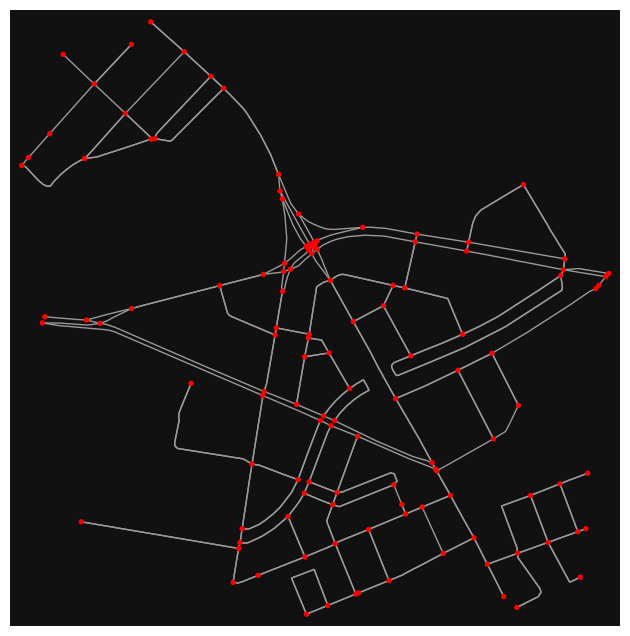

In [51]:
# get a street network and plot it with all edge intersections
point = 55.667708, 12.596266
G = ox.graph_from_point(point, network_type="drive", dist=500)
ox.plot_graph(G, node_color="r");

请注意创建节点集群的复杂交叉点。

我们将指定此网络中彼此具有 15 米缓冲区的任何节点都是同一交叉路口的一部分。 根据您正在检查的社区中的街道设计标准调整此公差，并使用投影图以有意义的单位（如米）工作。 我们还将指定我们不希望在我们的合并交叉点列表中返回死胡同。

In [52]:
# get a GeoSeries of consolidated intersections
G_proj = ox.project_graph(G)
intersections = ox.consolidate_intersections(
    G_proj, rebuild_graph=False, tolerance=15, dead_ends=False
)
len(intersections)

73

In [53]:
# compare to number of nodes in original graph
len(G)

122

请注意，这些清理后的交叉路口为我们提供了更准确的交叉路口计数和密度，但不会改变或集成网络拓扑。

为此，我们需要**重建图表**。

In [54]:
# consolidate intersections and rebuild graph topology
# this reconnects edge geometries to the new consolidated nodes
G2 = ox.consolidate_intersections(G_proj, rebuild_graph=True, tolerance=15, dead_ends=False)
len(G2)

76

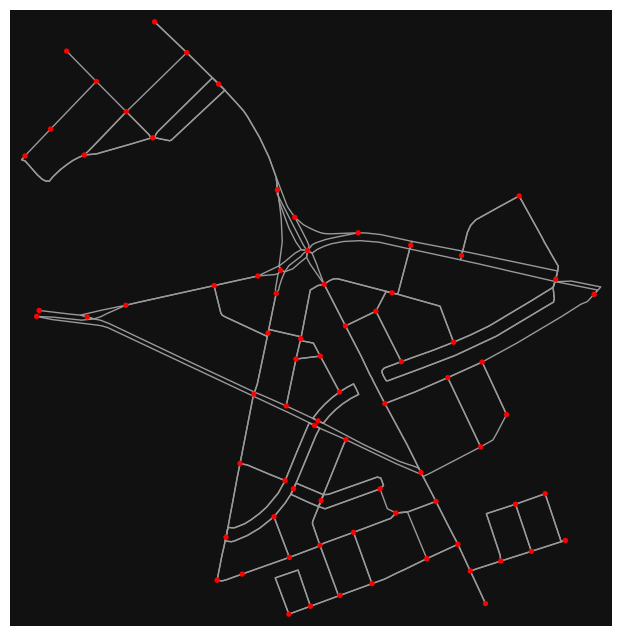

In [55]:
fig, ax = ox.plot_graph(G2, node_color="r")

请注意交通圈的许多节点是如何合并到一个新的单个质心节点中的，边缘几何形状被扩展以连接到它。 类似的合并发生在分开的道路的交叉口。

与`rebuild_graph=False`相比，使用`rebuild_graph=True`运行`consolidate_intersections`可能会产生一些（但不是非常）不同的交叉点计数/密度。 不同之处在于后者只是合并重叠的缓冲节点点，而前者在合并之前检查重叠节点缓冲区的拓扑。

这可以防止拓扑上远离但空间上接近的节点被合并。 例如：

   - 街道交叉口可能位于高速公路立交桥与入口匝道交叉口的正下方。 我们不想将它们合并在一起并连接它们的边缘：它们是道路系统中不同的交叉点。
   - 在居民区，有护柱的街道可能会在紧邻十字路口或交通环岛的地方形成死胡同。 我们不想将这个死胡同与交叉路口合并并连接它们的边缘。

这些例子说明了（二维）几何上的邻近性，但拓扑上的远程性。 因此，在某些情况下，我们可能会在使用 rebuild_graph=True 时期望更高的交集计数，因为在这些情况下合并时会更加谨慎。 权衡是它具有比“rebuild_graph=False”更高的时间复杂度。

## 清理网络外围

这与简化有关。 OSMnx 默认情况下（clean_periphery 参数等于 True）将您请求的区域缓冲 0.5 公里，然后在这个更大的缓冲区域内检索街道网络。 然后它简化了拓扑，使节点代表街道的交叉点（而不是包括所有间隙 OSM 节点）。 然后它计算这个更大网络中每个节点的（无向）度。 接下来，它会根据您请求的实际区域（通过边界框或多边形）截断该网络。 最后，它将节点度值的字典保存为图形属性。

这有两个主要好处。 首先，它会清除外围的杂散伪边缘。 如果 clean_periphery=False，则所请求区域内的外围非交叉点节点看起来是死胡同，因为通向该区域外交叉点的边缘的其余部分将被忽略。 如果 clean_periphery=True，则首先创建更大的图，允许将这些边简化为它们的真实交点，允许在截断到实际请求的区域后修剪它们的整体。 其次，它通过以下两种方式给出准确的节点度数：a）计算节点邻居，即使它们落在保留网络之外（所以你不会声称度数为 4 的节点是度数为 2，因为它的邻居中只有 2 个位于该区域内）， 和 b) 不将所有那些杂散的假边的终点节点计为死胡同，否则会严重增加度数 = 1 的节点的数量，即使这些节点实际上只是被砍掉的街道中间的间隙节点 路口之间的段。

请参阅下面的两个示例。

In [56]:
# get some bbox
bbox = ox.utils_geo.bbox_from_point((45.518698, -122.679964), dist=300)
north, south, east, west = bbox

d:\work\miniconda3\envs\OSMNX\lib\site-packages\osmnx\graph.py:488: UserWarning: the graph-level street_count attribute will likely be inaccurate when you set clean_periphery=False
  warnings.warn(msg)


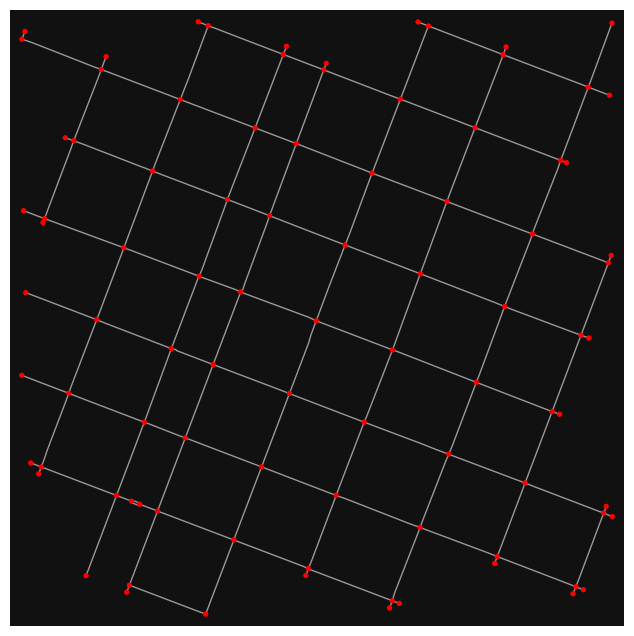

In [57]:
G = ox.graph_from_bbox(north, south, east, west, network_type="drive", clean_periphery=False)
ox.plot_graph(G, node_color="r");

In [58]:
# the node degree distribution for this graph has many false cul-de-sacs
k = dict(G.degree())
{n: list(k.values()).count(n) for n in range(max(k.values()) + 1)}

{0: 0, 1: 30, 2: 2, 3: 6, 4: 52}

在上方，注意所有外围杂散边缘存根。 在下面，请注意这些已被清理，并且节点度对于可能超出请求区域限制的更广泛的街道网络是准确的。

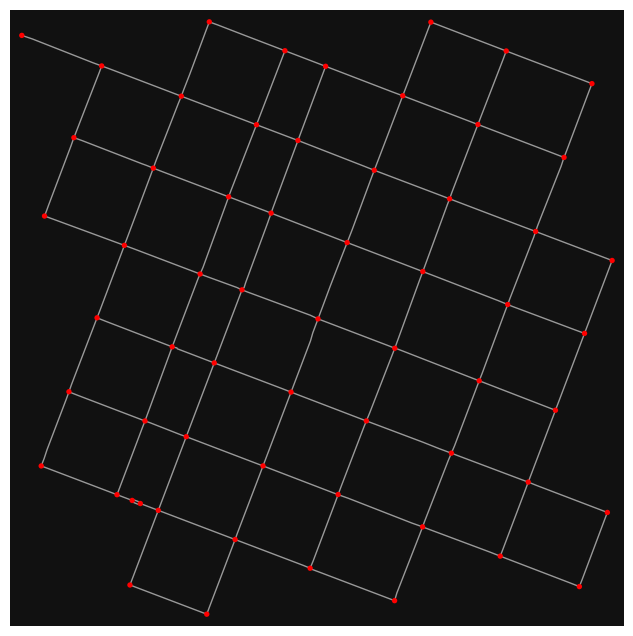

In [59]:
G = ox.graph_from_bbox(north, south, east, west, network_type="drive")
ox.plot_graph(G, node_color="r");

In [60]:
# the streets per node distribution for this cleaned up graph is more accurate
# dict keys = count of streets emanating from the node (ie, intersections and dead-ends)
# dict vals = number of nodes with that count
k = nx.get_node_attributes(G, "street_count")
{n: list(k.values()).count(n) for n in range(max(k.values()) + 1)}

{0: 0, 1: 0, 2: 0, 3: 3, 4: 57}

# 自定义过滤器和其他基础设施类型

使用自定义过滤器来微调您的网络。 OSMnx 使用 `network_type` 预设来查询允许步行、骑自行车、驾车等的街道。您可以通过传递 `custom_filter` 来覆盖它，以在图表中指定您想要的特定 OSM 方式。

34 motorway


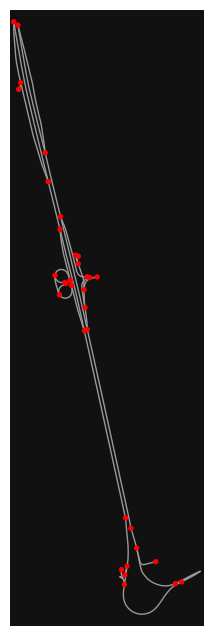

11 primary


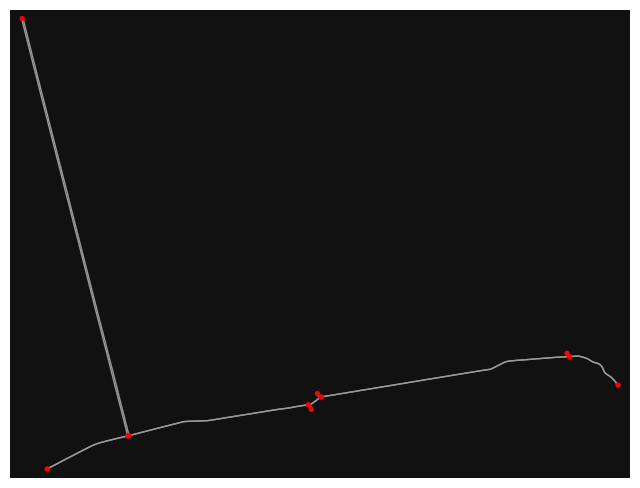

45 motorway + primary


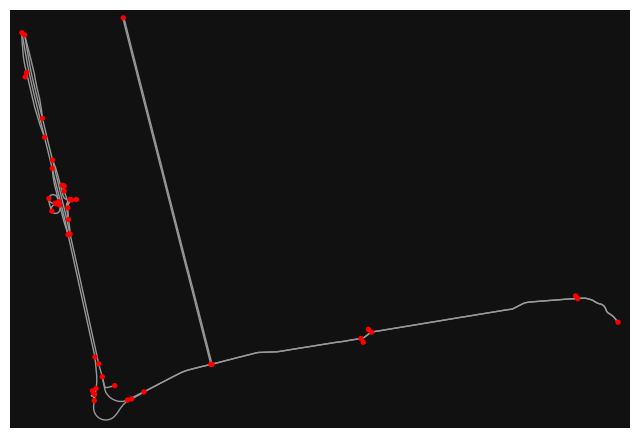

In [61]:
place = {"city": "Berkeley", "state": "California"}

# only get motorway ways
cf = '["highway"~"motorway"]'
G = ox.graph_from_place(place, network_type="drive", custom_filter=cf)
print(len(G), "motorway")
ox.plot_graph(G, node_color="r");

# only get primary ways
cf = '["highway"~"primary"]'
G = ox.graph_from_place(place, network_type="drive", custom_filter=cf)
print(len(G), "primary")
ox.plot_graph(G, node_color="r");

# use the pipe (|) as 'or' operator
cf = '["highway"~"motorway|primary"]'
G = ox.graph_from_place(place, network_type="drive", custom_filter=cf)
print(len(G), "motorway + primary")
ox.plot_graph(G, node_color="r");

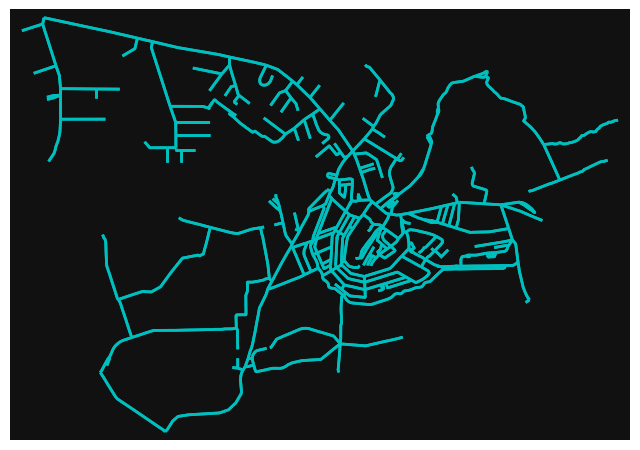

In [63]:
# network of the canals of amsterdam
place = "Amsterdam, Netherlands"
G = ox.graph_from_place(place, custom_filter='["waterway"~"canal"]')
ox.plot_graph(G, edge_color="c", edge_linewidth=2, node_size=0);

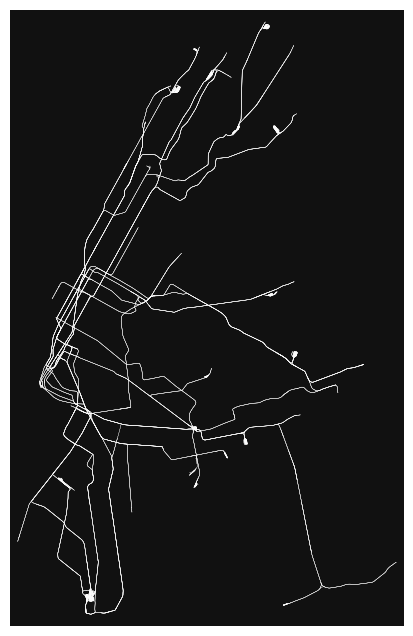

In [64]:
# get NY subway rail network
# note this is rail *infrastructure* and thus includes crossovers, sidings, spurs, yards, etc
# for station-based rail network, you should download a station adjacency matrix elsewhere
ox.settings.useful_tags_way += ["railway"]
G = ox.graph_from_place(
    "New York, New York, USA",
    retain_all=False,
    truncate_by_edge=True,
    simplify=True,
    custom_filter='["railway"~"subway"]',
)

ox.plot_graph(G, node_size=0, edge_color="w", edge_linewidth=0.2);

要下载整个国家/地区的道路网络，您通常需要将查询限制为仅限高速公路之类的内容，以适应您计算机的 RAM。 对于大型查询，例如整个比利时，OSMnx 会将您的查询细分为多个服务器请求以下载所有数据，然后组合图。

In [ ]:
# %%time
# # get only motorways, trunks, and their links in all of Belgium
# # takes a couple minutes to do all the downloading and processing
# # OSMnx automatically divides up the query into multiple requests to not overload server
# cf = '["highway"~"motorway|motorway_link|trunk|trunk_link"]'
# G = ox.graph_from_place("Belgium", network_type="drive", custom_filter=cf)
# ox.plot_graph(G, node_size=0);

Commented out because kernel dies in docker.

# pyrosm

使用 pyrosm 代替大型数据集或使用自定义过滤器获得更多灵活性：https://pyrosm.readthedocs.io/en/latest/basics.html#read-street-networks

In [2]:
from pyrosm import OSM
from pyrosm import get_data
fp = get_data("helsinki_pbf")
# Initialize the OSM parser object
osm = OSM(fp)

d:\work\miniconda3\envs\OSMNX\lib\site-packages\pyrosm\pyrosm.py:576: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  gdf = get_poi_data(
d:\work\miniconda3\envs\OSMNX\lib\site-packages\geopandas\array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(


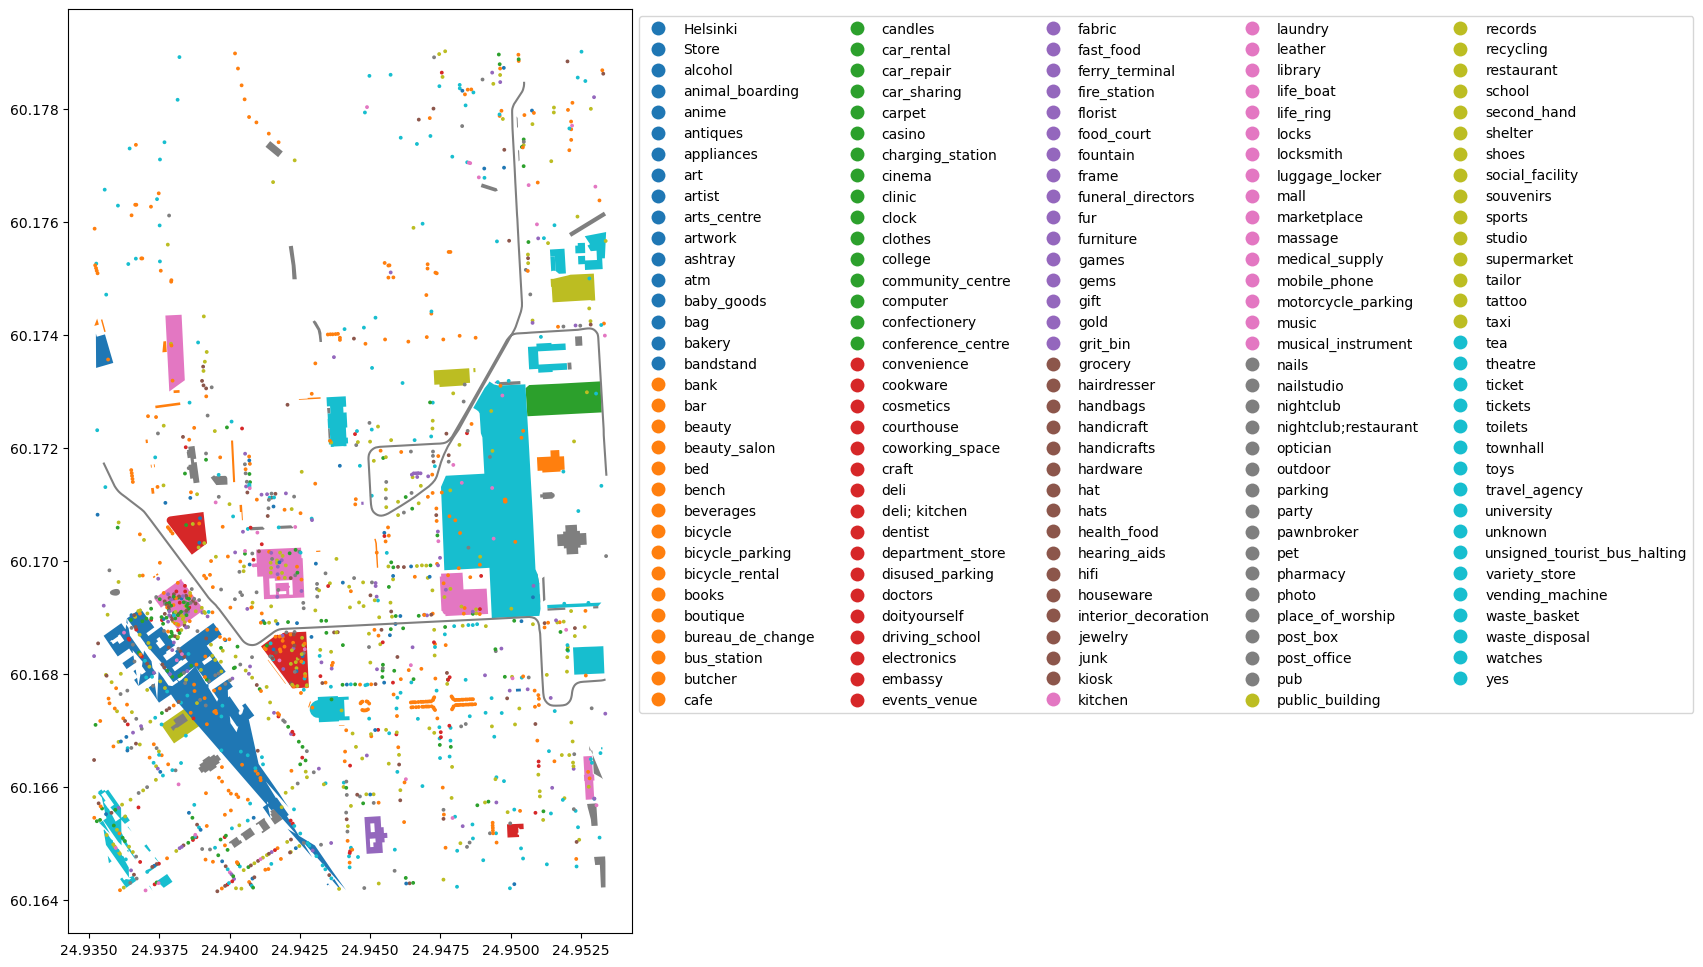

In [3]:
# Read POIs such as amenities and shops
# =====================================

# By default pyrosm reads all elements having "amenity", "shop" or "tourism" tag
# Here, let's read only "amenity" and "shop" by applying a custom filter that
# overrides the default filtering mechanism
custom_filter = {'amenity': True, "shop": True}
pois = osm.get_pois(custom_filter=custom_filter)

# Gather info about POI type (combines the tag info from "amenity" and "shop")
pois["poi_type"] = pois["amenity"]
pois["poi_type"] = pois["poi_type"].fillna(pois["shop"])

# Plot
ax = pois.plot(column='poi_type', markersize=3, figsize=(12,12), legend=True, legend_kwds=dict(loc='upper left', ncol=5, bbox_to_anchor=(1, 1)))

d:\work\miniconda3\envs\OSMNX\lib\site-packages\geopandas\array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(


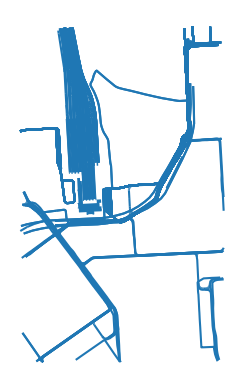

In [4]:
# Test reading all transit related data (bus, trains, trams, metro etc.)
# Exclude nodes (not keeping stops, etc.)
routes = ["bus", "ferry", "railway", "subway", "train", "tram", "trolleybus"]
rails = ["tramway", "light_rail", "rail", "subway", "tram"]
bus = ['yes']
transit = osm.get_data_by_custom_criteria(custom_filter={
                                        'route': routes,
                                        'railway': rails,
                                        'bus': bus,
                                        'public_transport': True},
                                        # Keep data matching the criteria above
                                        filter_type="keep",
                                        # Do not keep nodes (point data)    
                                        keep_nodes=False, 
                                        keep_ways=True, 
                                        keep_relations=True)
ax = transit.plot()
ax.axis("off");